In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, confusion_matrix

from mlmicrophysics.metrics import hellinger_distance, r2_corr, root_mean_squared_error


In [2]:
!ls ../models/cam_sd_model_base_full_moredata/

dnn_classifier_scores.csv  dnn_qr_class_fortran.nc
dnn_nc_class.h5            dnn_qr_pos.h5
dnn_nc_class_fortran.nc    dnn_qr_pos_fortran.nc
dnn_nc_pos.h5              dnn_regressor_scores.csv
dnn_nc_pos_fortran.nc      input_scale_values.csv
dnn_nr_class.h5            meta_test.csv
dnn_nr_class_fortran.nc    output_scale_values.csv
dnn_nr_neg.h5              test_cam_labels.csv
dnn_nr_neg_fortran.nc      test_cam_values.csv
dnn_nr_pos.h5              test_prediction_labels.csv
dnn_nr_pos_fortran.nc      test_prediction_values.csv
dnn_qr_class.h5


In [3]:
# dir_tau = "/glade/pcisl/aiml/ggantos/cam_run5_model_base_full/"
dir_sd = "../models/cam_sd_model_base_full_moredata/"

In [4]:
# classifier_scores_tau = pd.read_csv(join(dir_tau, "dnn_classifier_scores.csv"))
# regressor_scores_tau = pd.read_csv(join(dir_tau, "dnn_regressor_scores.csv"))
classifier_scores_sd = pd.read_csv(os.path.join(dir_sd, "dnn_classifier_scores.csv"))
regressor_scores_sd = pd.read_csv(os.path.join(dir_sd, "dnn_regressor_scores.csv"))


In [5]:
classifier_scores_sd

,Output,accuracy,heidke,peirce
0,qrtend_sd,0.988212,0.955801,0.955639
1,nctend_sd,0.973544,0.946328,0.947011
2,nrtend_sd,0.981866,0.966483,0.966622


In [6]:
regressor_scores_sd

,Output,rmse,mae,r2,hellinger
0,qrtend_sd_1,0.362725,0.205582,0.958848,0.000892
1,nctend_sd_1,0.158392,0.098289,0.993627,0.000515
2,nrtend_sd_-1,0.140099,0.071599,0.992577,0.002009
3,nrtend_sd_1,0.273238,0.149724,0.955609,0.001120


In [7]:
test_pred_labels = pd.read_csv(os.path.join(dir_sd, "test_prediction_labels.csv"), index_col="index") 
test_pred_values = pd.read_csv(os.path.join(dir_sd, "test_prediction_values.csv"), index_col="index") 
test_cam_labels = pd.read_csv(os.path.join(dir_sd, "test_cam_labels.csv"), index_col="index")
test_cam_values = pd.read_csv(os.path.join(dir_sd, "test_cam_values.csv"), index_col="index") 


/Users/ggantos/miniconda3/envs/ncar/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
meta_test = pd.read_csv(os.path.join(dir_sd, "meta_test.csv"), index_col="index")


In [9]:
mg2_test = meta_test.loc[:, ["qrtend_MG2", "nctend_MG2", "nrtend_MG2"]]
mg2_test.loc[mg2_test["qrtend_MG2"] > 0, "qrtend_MG2"] = np.log10(mg2_test.loc[mg2_test["qrtend_MG2"] > 0, "qrtend_MG2"])
mg2_test.loc[mg2_test["nctend_MG2"] < 0, "nctend_MG2"] = np.log10(-mg2_test.loc[mg2_test["nctend_MG2"] < 0, "nctend_MG2"])
mg2_test.loc[mg2_test["nrtend_MG2"] < 0, "nrtend_MG2"] = np.log10(-mg2_test.loc[mg2_test["nrtend_MG2"] < 0, "nrtend_MG2"])
mg2_test.loc[mg2_test["nrtend_MG2"] > 0, "nrtend_MG2"] = np.log10(mg2_test.loc[mg2_test["nrtend_MG2"] > 0, "nrtend_MG2"])

In [10]:
reg_scores = pd.read_csv(os.path.join(dir_sd, "dnn_regressor_scores.csv"), index_col="Output")
print(reg_scores)


                  rmse       mae        r2  hellinger
Output                                               
qrtend_sd_1   0.362725  0.205582  0.958848   0.000892
nctend_sd_1   0.158392  0.098289  0.993627   0.000515
nrtend_sd_-1  0.140099  0.071599  0.992577   0.002009
nrtend_sd_1   0.273238  0.149724  0.955609   0.001120


In [11]:
test_pred_values.columns


Index(['qrtend_sd_1', 'nctend_sd_1', 'nrtend_sd_-1', 'nrtend_sd_1'], dtype='object')

In [12]:
scores = {"rmse": root_mean_squared_error, "mae": mean_absolute_error, 
          "r2": r2_corr, "hellinger": hellinger_distance}
mg2_scores = pd.DataFrame(0, columns=reg_scores.columns, index=reg_scores.index)
for score in reg_scores.columns:
    mg2_scores.loc["qrtend_sd_1", 
                   score] = scores[score](test_cam_values.loc[test_cam_labels["qrtend_sd"] == 1, "qrtend_sd"],
                                                      mg2_test.loc[test_cam_labels["qrtend_sd"] == 1, "qrtend_MG2"])
    mg2_scores.loc["nctend_sd_1", 
                   score] = scores[score](test_cam_values.loc[test_cam_labels["nctend_sd"] == 1, "nctend_sd"],
                                                      mg2_test.loc[test_cam_labels["nctend_sd"] == 1, "nctend_MG2"])
    mg2_scores.loc["nrtend_sd_-1", 
                   score] = scores[score](test_cam_values.loc[test_cam_labels["nrtend_sd"] == -1, "nrtend_sd"],
                                                      mg2_test.loc[test_cam_labels["nrtend_sd"] == -1, "nrtend_MG2"])
    mg2_scores.loc["nrtend_sd_1", 
                   score] = scores[score](test_cam_values.loc[test_cam_labels["nrtend_sd"] == 1, "nrtend_sd"],
                                                      mg2_test.loc[test_cam_labels["nrtend_sd"] == 1, "nrtend_MG2"])

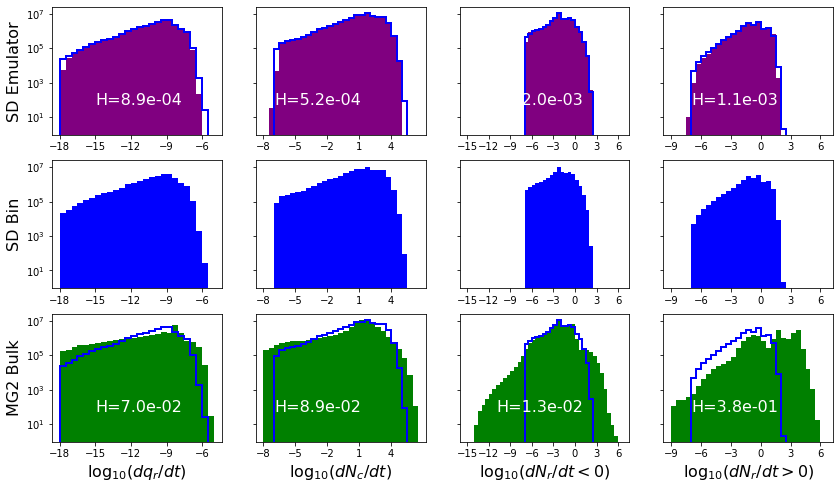

In [13]:
fig, axes = plt.subplots(3, 4, figsize=(14, 8), sharey=True)
bins = dict(qr=np.arange(-18, -4.5, 0.5),
            nc=np.arange(-8, 7, 0.5),
            nr_neg=np.arange(-15, 7, 0.5),
            nr_pos=np.arange(-9, 7, 0.5))
ticks = dict(qr=np.arange(-18, -4, 3),
             nc=np.arange(-8, 7, 3),
             nr_neg=np.arange(-15, 7, 3),
             nr_pos=np.arange(-9, 7, 3))
y_labels = ["SD Emulator", "SD Bin", "MG2 Bulk"]
x_labels = ["$\log_{10}(dq_r/dt)$", "$\log_{10}(dN_c/dt)$", 
            "$\log_{10}(dN_r/dt < 0)$", "$\log_{10}(dN_r/dt > 0)$"]
axes[0, 0].hist(test_pred_values.loc[test_cam_labels["qrtend_sd"] == 1, "qrtend_sd_1"], bins=bins["qr"], color="purple")
axes[1, 0].hist(test_cam_values.loc[test_cam_labels["qrtend_sd"] == 1, "qrtend_sd"], bins=bins["qr"], color="blue")
axes[2, 0].hist(mg2_test.loc[test_cam_labels["qrtend_sd"] == 1, "qrtend_MG2"], 
                bins=bins["qr"], color="green")
axes[0, 0].hist(test_cam_values.loc[test_cam_labels["qrtend_sd"] == 1, "qrtend_sd"], 
                bins=bins["qr"], color="blue", histtype="step", lw=2)
axes[2, 0].hist(test_cam_values.loc[test_cam_labels["qrtend_sd"] == 1, "qrtend_sd"], 
                bins=bins["qr"], color="blue", histtype="step", lw=2)

axes[0, 0].set_yscale("log")
axes[0, 1].hist(test_pred_values.loc[test_cam_labels["nctend_sd"] == 1, "nctend_sd_1"], bins=bins["nc"], color="purple")
axes[1, 1].hist(test_cam_values.loc[test_cam_labels["nctend_sd"] == 1, "nctend_sd"], bins=bins["nc"], color="blue")
axes[2, 1].hist(mg2_test.loc[test_cam_labels["nctend_sd"] == 1, "nctend_MG2"], 
                bins=bins["nc"], color="green")
axes[0, 1].hist(test_cam_values.loc[test_cam_labels["nctend_sd"] == 1, "nctend_sd"], 
                bins=bins["nc"], color="blue", histtype="step", lw=2)
axes[2, 1].hist(test_cam_values.loc[test_cam_labels["nctend_sd"] == 1, "nctend_sd"], 
                bins=bins["nc"], color="blue", histtype="step", lw=2)

axes[0, 2].hist(test_pred_values.loc[test_cam_labels["nrtend_sd"] == -1, "nrtend_sd_-1"], bins=bins["nr_neg"], color="purple")
axes[1, 2].hist(test_cam_values.loc[test_cam_labels["nrtend_sd"] == -1, "nrtend_sd"], bins=bins["nr_neg"], color="blue")
axes[2, 2].hist(mg2_test.loc[test_cam_labels["nrtend_sd"] == -1, "nrtend_MG2"], 
                bins=bins["nr_neg"], color="green")
axes[0, 2].hist(test_cam_values.loc[test_cam_labels["nrtend_sd"] == -1, "nrtend_sd"], 
                bins=bins["nr_neg"], color="blue", histtype="step", lw=2)
axes[2, 2].hist(test_cam_values.loc[test_cam_labels["nrtend_sd"] == -1, "nrtend_sd"], 
                bins=bins["nr_neg"], color="blue", histtype="step", lw=2)


axes[0, 3].hist(test_pred_values.loc[test_cam_labels["nrtend_sd"] == 1, "nrtend_sd_1"], bins=bins["nr_pos"], color="purple")
axes[1, 3].hist(test_cam_values.loc[test_cam_labels["nrtend_sd"] == 1, "nrtend_sd"], bins=bins["nr_pos"], color="blue")
axes[2, 3].hist(mg2_test.loc[test_cam_labels["nrtend_sd"] == 1, "nrtend_MG2"], 
                bins=bins["nr_pos"], color="green")
axes[0, 3].hist(test_cam_values.loc[test_cam_labels["nrtend_sd"] == 1, "nrtend_sd"], 
                bins=bins["nr_pos"], color="blue", histtype="step", lw=2)
axes[2, 3].hist(test_cam_values.loc[test_cam_labels["nrtend_sd"] == 1, "nrtend_sd"], 
                bins=bins["nr_pos"], color="blue", histtype="step", lw=2)

for i in range(3):
    for j, out in enumerate(["qr", "nc", "nr_neg", "nr_pos"]):
        axes[i, j].set_xticks(ticks[out])
    axes[i, 0].set_ylabel(y_labels[i], fontsize=16)
x_pos = [-15, -7, -11, -7]
for j in range(4):
    axes[0, j].text(x_pos[j], 50, f"H={reg_scores.iloc[j, 3]:1.1e}", fontsize=16, color='w')
    axes[2, j].text(x_pos[j], 50, f"H={mg2_scores.iloc[j, 3]:1.1e}", fontsize=16, color='w')

    axes[2, j].set_xlabel(x_labels[j], fontsize=16)
plt.savefig(os.path.join(".", "tendency_hist.pdf"), bbox_inches="tight")


In [14]:
test_cam_values.loc[test_cam_labels["qrtend_sd"] == 1, "qrtend_sd"].shape

(26961411,)